### Created on 2023
### @author: S.W

----

# Pytorch

----

## CIFAR-10 데이터셋으로 이미지 분류 해보기 - MLP

### 0. CIFAR-10 데이터

CIFAR-10은 Canadian Institute For Advanced Research (CIAR)에서 만든 컴퓨터 비전용 데이터셋입니다. 이 데이터셋은 32x32 크기의 컬러 이미지를 10개의 클래스로 분류하는 문제를 다룹니다.

CIFAR-10 데이터셋은 다음과 같은 10개의 클래스로 구성되어 있습니다.

- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

데이터셋은 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 구성되어 있습니다. 각 이미지는 RGB 채널 값으로 이루어져 있고, 픽셀 값은 0~255의 범위를 가집니다.

- https://www.cs.toronto.edu/~kriz/cifar.html

### 1. 학습에 필요한 라이브러리 불러오기

In [1]:
import numpy as np

# 시각화 관련 라이브러리 불러오기
import PIL
import matplotlib 
import matplotlib.pyplot as plt

# 딥러닝 관련 라이브러리인 pytorch 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torchvision.transforms as transforms

torch.cuda.device_count() 함수는 시스템에 연결된 GPU 장치의 수를 반환합니다. 반환값이 0인 경우, 시스템에 GPU가 없는 것입니다.

torch.cuda.is_available() 함수는 PyTorch에서 CUDA (NVIDIA의 GPU를 사용하는 라이브러리)가 사용 가능한지 여부를 확인합니다. 이 함수는 True 또는 False 값을 반환합니다. GPU가 설정되어 있지 않은 경우, PyTorch는 CPU를 사용하여 연산을 수행합니다.

In [2]:
# GPU 사용 가능 여부 확인
print("Num GPUs Available: ", torch.cuda.device_count())

# GPU가 설정되어 있는지 확인
print(torch.cuda.is_available())

Num GPUs Available:  1
True


### 2. CIFAR-10 데이터 불러오기 & 이미지 데이터 전처리

#### 이미지 데이터 전처리

In [3]:
# CIFAR-10 데이터셋 전처리
train_transform = transforms.Compose([
    RandomCrop(32, padding=4),  # 4겹의 패딩 후 32x32의 크기로 이미지를 뽑아냄.
    RandomHorizontalFlip(),     # 이미지가 주어진 확률(default = 0.5)로 가로로 뒤집음.
    ToTensor(),                 # 0~255의 픽셀 값을 0과 1사이의 값으로 변환
    
    # 데이터를 -1과 1사이의 값으로 변경, (평균이 0.5 표준편차가 0.5인 데이터)
    Normalize((0.5, 0.5, 0.5), # 채널 별 평균
              (0.5, 0.5, 0.5)) # 채널 별 표준편차 값  
    
])

test_transform = transforms.Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# pytorch에 내장되어 있는 CIFAR-10 데이터 셋 불러오기
train_dataset = CIFAR10(root="./data", train=True, transform=train_transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=test_transform, download=True)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 데이터 셋의 전반적인 정보 확인
train_dataset, test_dataset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

### 3. 모델 정의

In [7]:
# 모델 정의
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
# 모델 초기화
model = DNN().cuda()#.to(device)

### 4. 모델 학습

In [9]:
# 손실함수, 최적화 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.cuda()#.to(device)
        labels = labels.cuda()#.to(device)

        optimizer.zero_grad()

        outputs = model(images).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss / len(train_loader)))

Epoch 1 - Training loss: 1.8015
Epoch 2 - Training loss: 1.6279
Epoch 3 - Training loss: 1.5549
Epoch 4 - Training loss: 1.5121
Epoch 5 - Training loss: 1.4665
Epoch 6 - Training loss: 1.4416
Epoch 7 - Training loss: 1.4146
Epoch 8 - Training loss: 1.3956
Epoch 9 - Training loss: 1.3755
Epoch 10 - Training loss: 1.3623


### 5. 모델 평가

In [10]:
# 테스트
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()#.to(device)
        labels = labels.cuda()#.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on test set: {:.2f}%".format(100 * correct / total))

Accuracy on test set: 49.71%


## CIFAR-10 데이터셋으로 이미지 분류 해보기 - CNN

### 1. 학습에 필요한 라이브러리 불러오기 - 생략
### 2. CIFAR-10 데이터 불러오기

#### 이미지 데이터 전처리

In [11]:
# CIFAR-10 데이터셋 전처리
train_transform = transforms.Compose([
    RandomCrop(32, padding=4),  # 4겹의 패딩 후 32x32의 크기로 이미지를 뽑아냄.
    RandomHorizontalFlip(),     # 이미지가 주어진 확률(default = 0.5)로 가로로 뒤집음.
    ToTensor(),                 # 0~255의 픽셀 값을 0과 1사이의 값으로 변환
    
    # 데이터를 -1과 1사이의 값으로 변경, (평균이 0.5 표준편차가 0.5인 데이터)
    Normalize((0.5, 0.5, 0.5), # 채널 별 평균
              (0.5, 0.5, 0.5)) # 채널 별 표준편차 값  
    
])

test_transform = transforms.Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# pytorch에 내장되어 있는 CIFAR-10 데이터 셋 불러오기
train_dataset = CIFAR10(root="./data", train=True, transform=train_transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=test_transform, download=True)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 3. 모델 정의

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(4 * 4 * 256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(-1, 4 * 4 * 256)

        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.fc2(x)
        return x

# 모델 초기화
model = CNN().cuda()#.to(device)

### 4. 모델 학습

In [14]:
# 손실함수, 최적화 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.cuda()#.to(device)
        labels = labels.cuda()#.to(device)

        optimizer.zero_grad()

        outputs = model(images).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Epoch {} - Training loss: {:.4f}".format(epoch+1, running_loss / len(train_loader)))

C:\Users\sangwoo\anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 - Training loss: 1.2261
Epoch 2 - Training loss: 0.8708
Epoch 3 - Training loss: 0.7405
Epoch 4 - Training loss: 0.6614
Epoch 5 - Training loss: 0.6050
Epoch 6 - Training loss: 0.5643
Epoch 7 - Training loss: 0.5181
Epoch 8 - Training loss: 0.4883
Epoch 9 - Training loss: 0.4579
Epoch 10 - Training loss: 0.4304


### 5. 모델 학습

In [15]:
# 테스트
correct = 0
total = 0
predicted_all = []
y_true_all = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()#.to(device)
        labels = labels.cuda()#.to(device)

        outputs = model(images).cuda()
        _, predicted = torch.max(outputs.data, 1)
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        predicted_all = predicted_all + list(predicted)
        y_true_all = y_true_all + list(labels)
        
print("Accuracy on test set: {:.2f}%".format(100 * correct / total))

Accuracy on test set: 83.79%


## 실제로 잘 맞췄는지 확인해보기

In [16]:
# 예측 라벨 값 확인
len(predicted_all), len(y_true_all)

(10000, 10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(80,52.8;496x369.6)
실제 라벨 값:  tensor(7, device='cuda:0') 
예측 라벨 값: tensor(7, device='cuda:0')


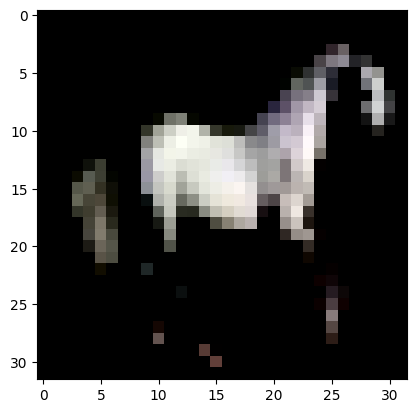

In [17]:
n = 13
batch_size = 128

val_1, val_2 = divmod(n, batch_size)

img = next(iter(test_loader))[val_1].numpy()

print(plt.imshow(np.transpose(img[val_2], (1, 2, 0))))
print("실제 라벨 값: ", y_true_all[n], "\n예측 라벨 값:", predicted_all[n])# 